In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import medmnist
from medmnist import INFO, Evaluator

We first work on a 2D dataset

In [2]:
data_flag = 'pathmnist'
#data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 30
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [3]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\ASUS\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\ASUS\.medmnist\pathmnist.npz
Using downloaded and verified file: C:\Users\ASUS\.medmnist\pathmnist.npz


In [4]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: C:\Users\ASUS\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K in

In [5]:
# visualization

train_dataset.montage(length=1)

C:\ProgramData\Anaconda3\envs\py37\lib\site-packages\medmnist\utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


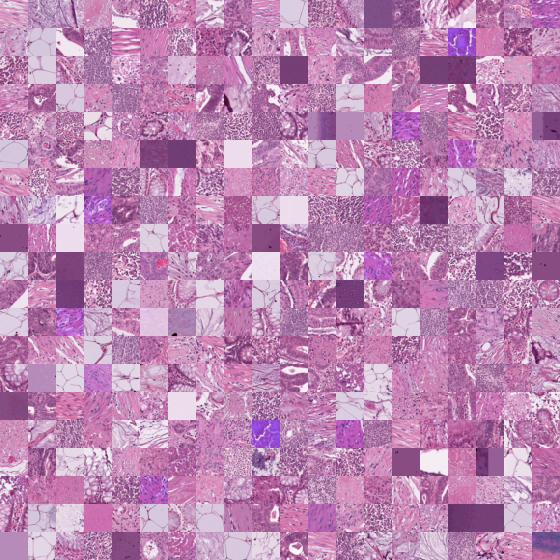

In [6]:
# montage

train_dataset.montage(length=20)

Resnet

In [7]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1, downsample=None,
                 groups=1, width_per_group=64):
        super(Bottleneck, self).__init__()

        width = int(out_channel * (width_per_group / 64.)) * groups

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=width,
                               kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, groups=groups,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=width, out_channels=out_channel*self.expansion,
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 blocks_num,
                 num_classes=1000,
                 include_top=True,
                 groups=1,
                 width_per_group=64):
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64

        self.groups = groups
        self.width_per_group = width_per_group

        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel,
                            channel,
                            downsample=downsample,
                            stride=stride,
                            groups=self.groups,
                            width_per_group=self.width_per_group))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel,
                                channel,
                                groups=self.groups,
                                width_per_group=self.width_per_group))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x


def resnet18(num_classes=1000,include_top=True):
    return ResNet(BasicBlock,[2,2,2,2], num_classes=num_classes,include_top=include_top)

def resnet50(num_classes=1000,include_top=True):
    return ResNet(Bottleneck,[3,4,6,3], num_classes=num_classes,include_top=include_top)


Next, we can start to train and evaluate!

In [8]:
# train for resnet18
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = resnet18(num_classes=n_classes).to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████████████████████████████████████████████████████████████████████████| 2813/2813 [01:02<00:00, 45.10it/s]


In [9]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in tqdm(data_loader):
            inputs, targets =inputs.to(device), targets.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.cpu().detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...


100%|██████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:18<00:00, 76.71it/s]


train  auc: 0.999  acc:0.946


100%|████████████████████████████████████████████████████████████████████████████████| 113/113 [00:01<00:00, 74.88it/s]

test  auc: 0.938  acc:0.664


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_50 = resnet50(num_classes=n_classes).to(device)
    
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model_50.parameters(), lr=lr, momentum=0.9)

In [11]:
# train for resnet50

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model_50.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model_50(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████████████████████████████████████████████████████████████████████████| 2813/2813 [02:23<00:00, 19.60it/s]


In [12]:
# evaluation

def test_50(split):
    model_50.eval()
    y_true = torch.tensor([]).to(device)
    y_score = torch.tensor([]).to(device)
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in tqdm(data_loader):
            inputs, targets =inputs.to(device), targets.to(device)
            outputs = model_50(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.cpu().numpy()
        y_score = y_score.cpu().detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test_50('train')
test_50('test')

==> Evaluating ...


100%|██████████████████████████████████████████████████████████████████████████████| 1407/1407 [00:31<00:00, 44.63it/s]


train  auc: 1.000  acc:0.995


100%|████████████████████████████████████████████████████████████████████████████████| 113/113 [00:02<00:00, 47.10it/s]

test  auc: 0.959  acc:0.789
